Showing how to do the contour, box, and line plots from "Density dependence and a colonization rule predict spatial patterning". This is Figs. 2, 3 for the serpentine data. The data itself is available on Dryad at https://doi.org/10.6078/D1MQ2V .

In [1]:
import dd_functions as dd
import numpy as np
import pandas as pd
from scipy.optimize import minimize_scalar
import scipy.stats as st

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [2]:
# Read in data
s_loc = 'Location_Of_Serpentine.csv'
spd = pd.read_csv(s_loc,dtype='Int64')
n0i = spd.sum().astype('Int64')
s0 = len(spd.columns)
n0 = n0i.sum()

In [3]:
# We already have the explicit bisection data (that is the raw data) so just create the fine scale fraction data
# The threshold is 128, since that is the smallest bisection we will use.
fr = dd.create_f(spd.T,thresh=128)
# Get unique species list
spl = fr['sp'].unique()

# Aggregate $\alpha$

In [4]:
# Get the preferred alpha value:
# Our bounds are TIGHT because this is sharply peaked around 1.0
al_ag = minimize_scalar(dd.loglikelihood,bounds=(0.9,1.1),method='bounded',
                args=(spd[0:128].sum().values.astype(int),n0i))

In [5]:
# Basically prefers METE
al_ag

     fun: 114.55677203242222
 message: 'Solution found.'
    nfev: 19
  status: 0
 success: True
       x: 1.000307007635585

In [6]:
# Compare likelihoods:
# Density dependent
print(dd.loglikelihood(al_ag.x,spd[0:128].sum().values.astype(int),n0i))
# METE
print(-np.sum(np.log(1/(n0i+1))))
# Random Placement
print(-np.sum(st.binom.logpmf(spd[0:128].sum().astype(int), n0i.astype(int), 0.5)))
# Can get deviance as |mete-density dependent|*2, then use this as the argument for a chi^2 distribution
# with one extra parameter (k=1). Then 1-CDF gives a p-value.
print("p-value: {:.3f}".format(
  1-st.chi2.cdf(2*(-np.sum(np.log(1/(n0i+1)))-dd.loglikelihood(al_ag.x,spd[0:128].sum().values.astype(int),n0i)),1)))

114.55677203242222
114.84688115523167
5188.5652342625945
p-value: 0.446


## Contours

In [7]:
# Get contour intervals
pc=0.05 # Want 95% contour intervals
nmax = max(n0i)
logrange,dda_int = dd.contours(al_ag.x,pc,nmax)
# Set up arrays for other distributions
bi_int = []
mete_int = []
for n in logrange:
    bi_int_t = st.binom.interval(1-pc,n,0.5)
    bi_int.append((bi_int_t[0]/n,bi_int_t[1]/n))
    mete_int.append((np.floor(pc/2*(n+1))/(n+1),np.ceil((1-pc/2)*(n+1))/(n+1)))

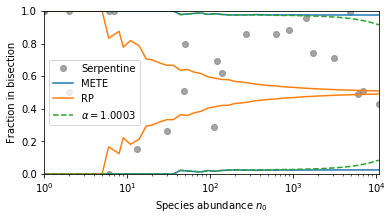

In [8]:
# Now plot these contour intervals
fig,ax = plt.subplots(figsize=(6,3))
colors = plt.get_cmap("tab10")
# Plot with abundance on x instead of rank ordering
# At the single bisection level, we can just sum the first 128 entries:
full_fr = (spd[0:128].sum()/n0i)
sptp = ax.semilogx(np.array(n0i.values),full_fr.values,'o',c=colors(7),alpha=0.7,label='Serpentine')
metep = ax.semilogx(logrange,mete_int,c=colors(0),label='METE')
bip = ax.semilogx(logrange,bi_int,c=colors(1),label='RP')
alp = ax.semilogx(logrange,dda_int,'--',c=colors(2),label=r'$\alpha={:.4f}$'.format(al_ag.x))
ax.legend((sptp[0],metep[0],bip[0],alp[0]),('Serpentine','METE','RP',r'$\alpha={:.4f}$'.format(al_ag.x)))
ax.set_ylim(0,1)
ax.set_xlim(1,nmax)
ax.set_ylabel('Fraction in bisection')
ax.set_xlabel(r'Species abundance $n_0$')
fig_name = 'FigureFilename.pdf'
plt.savefig(fig_name,format='pdf',bbox_inches='tight')

# Individual species at different scales

In [9]:
# Create fractions for eaach species
# Keep threshold at 128 everywhere
th = 128
# Divide into 2x2
inds4 = (spd.index//128*2+spd.index//8%2)
sfr4 = dd.create_f(spd.groupby(inds4).sum().T,thresh=th)
# Divide into 2x4
inds8 = (spd.index//64*2+spd.index//8%2)
sfr8 = dd.create_f(spd.groupby(inds8).sum().T,thresh=th)
# Divide into 4x4
inds16 = (spd.index//64*4+spd.index//4%4)
sfr16 = dd.create_f(spd.groupby(inds16).sum().T,thresh=th)
# Divide into 4x8
inds32 = (spd.index//32*4+spd.index//4%4)
sfr32 = dd.create_f(spd.groupby(inds32).sum().T,thresh=th)
# Divide into 8x8
inds64 = (spd.index//32*8+spd.index//2%8) # I think this is taking the nearest 4 cells and summing them together
sfr64 = dd.create_f(spd.groupby(inds64).sum().T,thresh=th)
# Divide into 8x16, so sum adjacent plots then compare.
sfr128 = dd.create_f(spd.groupby(spd.index//2).sum().T,thresh=th)
# Divide into 16x16
sfr256 = dd.create_f(spd.T,thresh=th)

In [10]:
# Start at 2x4, which is 3 points.
sp_al = np.zeros([len(spl),6]) # six is the number of scales
# For every species, get alpha at each scale.
for i,sp in enumerate(spl):
    # 2x4
    sal8 = minimize_scalar(dd.loglikelihood,bounds=(0.8,1.5),method='bounded',
                    args=(np.rint(sfr8[sfr8['sp']==sp]['frac']*sfr8[sfr8['sp']==sp]['n0']).astype(int),
                          sfr8[sfr8['sp']==sp]['n0']))
    # 4x4
    sal16 = minimize_scalar(dd.loglikelihood,bounds=(0.8,2.),method='bounded',
                    args=(np.rint(sfr16[sfr16['sp']==sp]['frac']*sfr16[sfr16['sp']==sp]['n0']).astype(int),
                          sfr16[sfr16['sp']==sp]['n0']))
    # 4x8
    sal32 = minimize_scalar(dd.loglikelihood,bounds=(0.8,2.),method='bounded',
                    args=(np.rint(sfr32[sfr32['sp']==sp]['frac']*sfr32[sfr32['sp']==sp]['n0']).astype(int),
                          sfr32[sfr32['sp']==sp]['n0']))
    # 8x8
    sal64 = minimize_scalar(dd.loglikelihood,bounds=(0.8,2.),method='bounded',
                    args=(np.rint(sfr64[sfr64['sp']==sp]['frac']*sfr64[sfr64['sp']==sp]['n0']).astype(int),
                          sfr64[sfr64['sp']==sp]['n0']))
    # 8x16
    sal128 = minimize_scalar(dd.loglikelihood,bounds=(0.8,2.),method='bounded',
                    args=(np.rint(sfr128[sfr128['sp']==sp]['frac']*sfr128[sfr128['sp']==sp]['n0']).astype(int),
                          sfr128[sfr128['sp']==sp]['n0']))
    # 16x16
    sal256 = minimize_scalar(dd.loglikelihood,bounds=(0.8,2.),method='bounded',
                    args=(np.rint(sfr256[sfr256['sp']==sp]['frac']*sfr256[sfr256['sp']==sp]['n0']).astype(int),
                          sfr256[sfr256['sp']==sp]['n0']))
    sp_al[i,:] = [sal8.x,sal16.x,sal32.x,sal64.x,sal128.x,sal256.x]

In [11]:
# Make a dataframe with these results
frac_a =[1/2**n for n in np.arange(3,9)] 
df_c = pd.DataFrame(sp_al,index=spl,columns = np.log2(frac_a))

In [12]:
# Don't plot 'EN' in the next few as we exclude it as an outlier

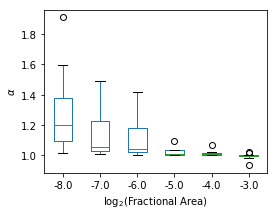

In [13]:
# Boxplots
fig,ax=plt.subplots(figsize=(4,3))
df_c.drop('EN').iloc[:, ::-1].plot(ax=ax,kind='box')
ax.set_ylabel(r'$\alpha$')
ax.set_xlabel(r'$\log_2$(Fractional Area)')
fig_name2 = 'FigureFilename.pdf'
plt.savefig(fig_name2,format='pdf',bbox_inches='tight')
plt.show()

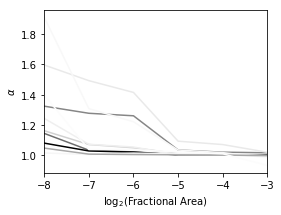

In [14]:
# Plot them all as lines:
fig,ax=plt.subplots(figsize=(4,3))
colors = cm.get_cmap('Greys')
n0max = max(n0i)
for sp in spl:
    if sp != 'EN':
        df_c.loc[sp].T.plot(ax=ax,c=colors(n0i[sp]/n0max),label=sp)
# if you want a legend, uncomment.
#ax.legend(ncol=2)
ax.set_xlabel(r'$\log_2$(Fractional Area)')
ax.set_ylabel(r'$\alpha$')
fig_name3 = 'FigureFilename.pdf'
plt.savefig(fig_name3,format='pdf',bbox_inches='tight')
plt.show()